# Project 4 Alireza Rashidi semantic segmentation on Derma HoVer-Net data set.

## Geting Data set:

In [1]:
# from google.colab import files     --> used to import data set file from local storage.
# uploaded = files.upload()

!wget https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep.zip

--2021-09-02 19:08:51--  https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 153334740 (146M) [application/zip]
Saving to: ‘consep.zip’

consep.zip          100%[===================>] 146.23M  11.4MB/s    in 25s     

2021-09-02 19:09:18 (5.78 MB/s) - ‘consep.zip’ saved [153334740/153334740]



In [2]:
!unzip consep.zip

Archive:  consep.zip
   creating: CoNSeP/
  inflating: CoNSeP/.DS_Store        
   creating: __MACOSX/
   creating: __MACOSX/CoNSeP/
  inflating: __MACOSX/CoNSeP/._.DS_Store  
   creating: CoNSeP/Test/
  inflating: CoNSeP/Test/.DS_Store   
   creating: __MACOSX/CoNSeP/Test/
  inflating: __MACOSX/CoNSeP/Test/._.DS_Store  
   creating: CoNSeP/Test/Images/
  inflating: CoNSeP/Test/Images/test_14.png  
   creating: __MACOSX/CoNSeP/Test/Images/
  inflating: __MACOSX/CoNSeP/Test/Images/._test_14.png  
  inflating: CoNSeP/Test/Images/test_9.png  
  inflating: __MACOSX/CoNSeP/Test/Images/._test_9.png  
  inflating: CoNSeP/Test/Images/test_8.png  
  inflating: __MACOSX/CoNSeP/Test/Images/._test_8.png  
  inflating: CoNSeP/Test/Images/test_12.png  
  inflating: __MACOSX/CoNSeP/Test/Images/._test_12.png  
  inflating: CoNSeP/Test/Images/test_13.png  
  inflating: __MACOSX/CoNSeP/Test/Images/._test_13.png  
  inflating: CoNSeP/Test/Images/test_11.png  
  inflating: __MACOSX/CoNSeP/Test/Images/._te

## Downloading segmentation_models from github:

In [3]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-km14dccb
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-km14dccb
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 2.8 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=0a224809e37f64fe1fc1618b8354f9e51a9b63428f18aa0f8786627932dda98a
  Stored in directory: /tmp/pip-ephem-wheel-cache-oogusrpi/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


## Importing libs:

In [4]:
import os
import shutil
import scipy.io
import numpy as np
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from PIL import Image
from imgaug import augmenters as iaa
import skimage
from skimage.color import label2rgb
import segmentation_models as sm
from segmentation_models.utils import set_trainable
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [5]:
dir_list = os.listdir(os.path.join('CoNSeP', 'Train'))
print("Train and Test folder contents:", dir_list)

Train and Test folder contents: ['Overlay', '.DS_Store', 'Images', 'Labels']


## Data visualization:

In [6]:
base_folder = 'CoNSeP'
sub_folder = ['Train', 'Test']
imgs, lbls, ovr, cls = 'Images', 'Labels', 'Overlay', 'imgs'
sample = 'train_10.mat'

# below line returns dict of ground truth datas with keys: inst_map, type_map, inst_type, inst_centroid
# so for this project we need only 'type_map' and we extract it's datas.
mat_info = scipy.io.loadmat(os.path.join(base_folder, sub_folder[0], lbls, sample))
print('Labels for {} : \n\n'.format(sample), mat_info['type_map']) 
print('\nimage {} shape:'.format(sample), mat_info['type_map'].shape)

Labels for train_10.mat : 

 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 3. 3. 3.]
 [0. 0. 0. ... 3. 3. 3.]
 [0. 0. 0. ... 3. 3. 3.]]

image train_10.mat shape: (1000, 1000)


In [7]:
print('max label value in data set: ', np.max(mat_info['type_map']))
print('min label value in data set: ', np.min(mat_info['type_map']))
unique, counts = np.unique(mat_info['type_map'], return_counts=True)
print('\noccurance of each label in {}:\n'.format(sample),dict(zip(unique, counts)))

max label value in data set:  7.0
min label value in data set:  0.0

occurance of each label in train_10.mat:
 {0.0: 722036, 1.0: 184, 2.0: 67718, 3.0: 131867, 5.0: 77327, 7.0: 868}


**Important point about labels:**

'type_map' is a 1000x1000 array where each pixel value denotes the class of that pixel. The map ranges from 0 to 7, where 7 is the total number of classes in CoNSeP.

we need to convert .mat label files for each feature to masked rgb for giving to Unet.

In [8]:
class_labels = ['back_ground','other', 'inflammatory', 'healthy epithelial', 'dysplastic/malignant epithelial', 'fibroblast', 'muscle', 'endothelial']

colors = [
    (255, 0, 0),        # red    (class 1)
    (0, 0, 255),        # blue  (class 2)
    (0, 255, 0),        # green  (class 3)
    (0, 255, 255),       # Cyan    (class 4)
    (255, 0, 255),       # purple    (class 5)
    (255, 255, 0),       # yellow    (class 6)
    (153, 153, 255),       # light-blue    (class 7)
]
sampleMask_img = label2rgb(mat_info['type_map'], colors=colors, bg_label=0, bg_color=(0, 0, 0))
print('masked rgb converted label of {}: '.format(sample), sampleMask_img.shape)

masked rgb converted label of train_10.mat:  (1000, 1000, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'masked train_10.png')

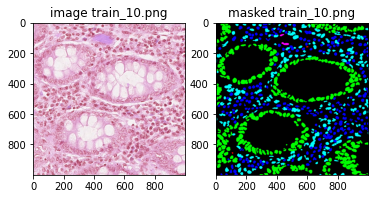

In [9]:
sample = 'train_10.png'
sample_img = cv2.imread(os.path.join(base_folder, sub_folder[0], imgs, sample))
# sample_img = sample_img.reshape(1, sample_img.shape[0], sample_img.shape[1], sample_img.shape[2])
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title('image {}'.format(sample))

plt.subplot(1, 2, 2)
plt.imshow(sampleMask_img)
plt.title('masked {}'.format(sample))

In [10]:
print(sampleMask_img.shape)
np.unique(sampleMask_img)

(1000, 1000, 3)


array([  0., 255.])

### Binary segmentation sample:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'other')

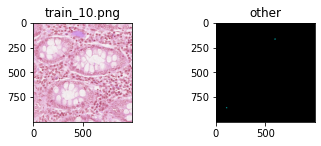

In [11]:
maskeds = []
for i in range(1, len(class_labels)):
    im = np.copy(mat_info['type_map'])
    im[im == i ] = 1
    im[im != 1] = 0
    maskeds.append(label2rgb(im, colors=[colors[3]], bg_label=0, bg_color=(0, 0, 0)))

plt.subplot(2, 2, 1)
plt.imshow(sample_img)
plt.title(sample)

plt.subplot(2, 2, 2)
plt.imshow(maskeds[0])
plt.title(class_labels[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'healthy epithelial')

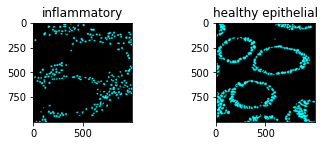

In [12]:
plt.subplot(2, 2, 1)
plt.imshow(maskeds[1])
plt.title(class_labels[2])

plt.subplot(2, 2, 2)
plt.imshow(maskeds[2])
plt.title(class_labels[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'fibroblast')

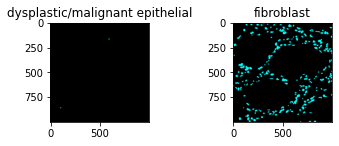

In [13]:
plt.subplot(2, 2, 1)
plt.imshow(maskeds[3])
plt.title(class_labels[4])

plt.subplot(2, 2, 2)
plt.imshow(maskeds[4])
plt.title(class_labels[5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'endothelial')

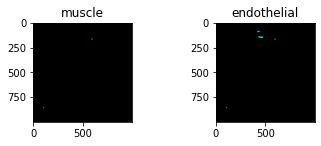

In [14]:
plt.subplot(2, 2, 1)
plt.imshow(maskeds[5])
plt.title(class_labels[6])

plt.subplot(2, 2, 2)
plt.imshow(maskeds[6])
plt.title(class_labels[7])

## Preprocess Data:

In [15]:
!mkdir CoNSeP/Train/augImages
!mkdir CoNSeP/Train/augImages/multiclass
!mkdir CoNSeP/Train/augImages/binary
!mkdir CoNSeP/Train/augImages/multiclass/mask
!mkdir CoNSeP/Train/augImages/binary/mask
!mkdir CoNSeP/Train/augImages/image
!mkdir CoNSeP/Train/maskedLabels
!mkdir CoNSeP/Test/maskedLabels
!mkdir CoNSeP/Train/maskedLabels/imgs
!mkdir CoNSeP/Train/Images/imgs
!mkdir CoNSeP/Test/maskedLabels/imgs
!mkdir CoNSeP/Test/Images/imgs
!mkdir CoNSeP/Train/binary/
!mkdir CoNSeP/Test/binary/



for i in range(1,len(class_labels)):    # for train
    os.mkdir(os.path.join(base_folder, sub_folder[0], 'binary', str(i) ))

for i in range(1,len(class_labels)):   # for test
    os.mkdir(os.path.join(base_folder, sub_folder[1], 'binary', str(i) ))

# os.mkdir('CoNSeP/Train/augImages')   # if you want to use pure python oncomment this.
# os.mkdir('CoNSeP/Train/maskedLabels')
# os.mkdir('CoNSeP/Test/maskedLabels')

### Creating masked images from labels (.mat files):

In [16]:
# dataGen = ImageDataGenerator(rescale=1./255, brightness_range=(0.8, 1.2))
# train_datagen = dataGen.flow_from_directory('CoNSeP/Train/Images', batch_size=32, target_size=(1000, 1000), class_mode='categorical')

def maskLabels(base_folder, sub_folder, lbls):    # this function is for multi-class mask generation.

    sub = 'Train' if sub_folder == 'Train' else 'Test'
    for label_file in tqdm( os.listdir(os.path.join(base_folder, sub, lbls)), desc='converting labels to mask for {}: '.format(sub) ):
        mat_label = scipy.io.loadmat(os.path.join(base_folder, sub, lbls, label_file))['type_map']
        maskImage = label2rgb(mat_label, colors=colors, bg_label=0, bg_color=(0, 0, 0))
        cv2.imwrite(os.path.join(base_folder, sub, 'maskedLabels', cls, '{}.png'.format(label_file.split('.')[0])), maskImage)

maskLabels(base_folder, sub_folder[0], lbls)   # for train
maskLabels(base_folder, sub_folder[1], lbls)   # for test

converting labels to mask for Test: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]


In [17]:
def binary_maskCreator(base_folder, sub_folder, class_labels, write=True):
    sub = 'Train' if sub_folder == 'Train' else 'Test'

    for i in tqdm(range(1, len(class_labels))):

        for label_file in tqdm( os.listdir(os.path.join(base_folder, sub, lbls)), desc='extracting label ({}) to mask in {}: '.format(class_labels[i], sub)):
            mat_label = scipy.io.loadmat(os.path.join(base_folder, sub, lbls, label_file))['type_map']
            mat_label[mat_label == i] = 1
            mat_label[mat_label != 1] = 0
            maskImage = label2rgb(mat_label, colors=[colors[3]], bg_label=0, bg_color=(0, 0, 0))
            
            if write:
                cv2.imwrite(os.path.join(base_folder, sub, 'binary', str(i), '{}.png'.format(label_file.split('.')[0])), maskImage)    


 

*   Here we will show some sampels that masked and saved in maskedLabels dir (for test and train):




100%|██████████| 3/3 [00:00<00:00,  6.84it/s]


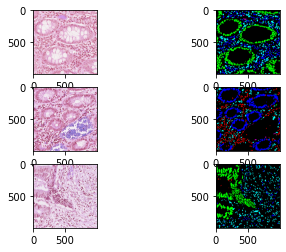

In [18]:
sample_files = ('train_10.png', 'test_10.png', 'train_1.png')

def imgMask_plot(sample_files):

    for i in tqdm(range(len(sample_files))):
      
        sub = sub_folder[0] if 'train' in sample_files[i] else sub_folder[1]

        sample_img = cv2.imread(os.path.join(base_folder, sub, imgs, sample_files[i]))
        mask_img = cv2.imread(os.path.join(base_folder, sub, 'maskedLabels', cls, sample_files[i]))

        plt.subplot(len(sample_files), 2, 2 * i + 1)
        plt.imshow(sample_img)

        plt.subplot(len(sample_files), 2, 2 * i + 2)
        plt.imshow(mask_img)

imgMask_plot(sample_files)

In [19]:
def moveTo_subDir(srcPath, destPath):
    list_dirPath = os.listdir(srcPath)
    for image in tqdm(list_dirPath, total=len(list_dirPath)):
        if image.endswith('.png'):
            shutil.move(os.path.join(srcPath, image), destPath)
    
src_trainImages = os.path.join(base_folder, sub_folder[0], imgs)
src_testImages = os.path.join(base_folder, sub_folder[1], imgs)

dest_trainImages = os.path.join(base_folder, sub_folder[0], imgs, cls)
dest_testImages = os.path.join(base_folder, sub_folder[1], imgs, cls)

dest_trainMaskedLabels = os.path.join(base_folder, sub_folder[0], 'maskedLabels', cls)
dest_testMaskedLabels = os.path.join(base_folder, sub_folder[1], 'maskedLabels', cls)

moveTo_subDir(src_trainImages, dest_trainImages)
moveTo_subDir(src_testImages, dest_testImages)

# shutil.move(src_trainImages, dest_trainImages)
# shutil.move(src_testImages, dest_testImages)

100%|██████████| 15/15 [00:00<00:00, 9767.82it/s]


Creating data set and saving them on numpy arrays to work with them.

In [20]:
def dataSet_from_Images(dir_path, h, w):    # this function creates Continuous dataset to store it on the ram (ndarray)

    images = os.listdir(dir_path)
    data_set = []
    for image in tqdm(images, total=len(images), desc="creating data set from dir {}: ".format(dir_path)):
        im = cv2.imread(os.path.join(dir_path, image))
        im = cv2.resize(im, (h, w), interpolation = cv2.INTER_AREA)
        data_set.append(im)

    return np.stack(data_set)

H = 256
W = 256
train_images = dataSet_from_Images(dest_trainImages, H, W)
train_maskedLabels = dataSet_from_Images(dest_trainMaskedLabels, H, W)   # this masks are for multi class segmentation..

creating data set from dir CoNSeP/Train/Images/imgs: 100%|██████████| 27/27 [00:00<00:00, 27.64it/s]
creating data set from dir CoNSeP/Train/maskedLabels/imgs: 100%|██████████| 27/27 [00:00<00:00, 57.91it/s]


### Extracting binary masks for binary classification:

resized images and masks (256,256) : 


Text(0.5, 1.0, 'mask')

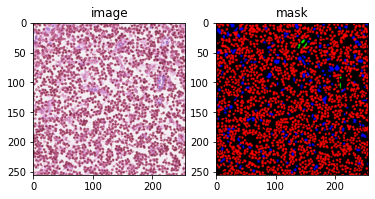

In [21]:
print('resized images and masks ({},{}) : '.format(H, W))
plt.subplot(1, 2, 1)
plt.imshow(train_images[0])
plt.title('image')

plt.subplot(1, 2, 2)
plt.imshow(train_maskedLabels[0])
plt.title('mask')

In [22]:
binary_maskCreator(base_folder, sub_folder[0], class_labels, True)
binary_maskCreator(base_folder, sub_folder[1], class_labels, True)

 14%|█▍        | 1/7 [00:06<00:38,  6.35s/it]
extracting label (inflammatory) to mask in Train:   0%|          | 0/27 [00:00<?, ?it/s]
extracting label (inflammatory) to mask in Train:   4%|▎         | 1/27 [00:00<00:05,  4.38it/s]
extracting label (inflammatory) to mask in Train:   7%|▋         | 2/27 [00:00<00:05,  4.38it/s]
extracting label (inflammatory) to mask in Train:  11%|█         | 3/27 [00:00<00:05,  4.27it/s]
extracting label (inflammatory) to mask in Train:  15%|█▍        | 4/27 [00:00<00:05,  4.34it/s]
extracting label (inflammatory) to mask in Train:  19%|█▊        | 5/27 [00:01<00:05,  4.38it/s]
extracting label (inflammatory) to mask in Train:  22%|██▏       | 6/27 [00:01<00:04,  4.32it/s]
extracting label (inflammatory) to mask in Train:  26%|██▌       | 7/27 [00:01<00:04,  4.33it/s]
extracting label (inflammatory) to mask in Train:  30%|██▉       | 8/27 [00:01<00:04,  4.35it/s]
extracting label (inflammatory) to mask in Train:  33%|███▎      | 9/27 [00:02<00:04,  4.

In [23]:
bin_path = os.path.join(base_folder,sub_folder[0] ,'binary')
masked_batches = []   # every batch in this list is for one class for example, masked_batches[0] is about masked images of recoreds according to class label 1 (other)
for i in range (1,len(class_labels)):
    masked_batches.append(dataSet_from_Images(os.path.join(bin_path, str(i)), H, W))


creating data set from dir CoNSeP/Train/binary/7: 100%|██████████| 27/27 [00:00<00:00, 57.27it/s]


### visualize one of batches in train batches:

Text(0.5, 1.0, 'mask img2 label other')

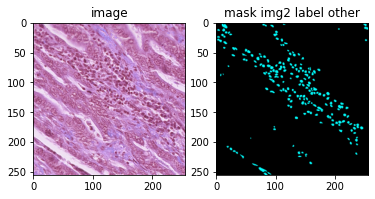

In [24]:
c = 1
s = 2

plt.subplot(1, 2, 1)
plt.imshow(train_images[s])   # sample 2
plt.title('image')

plt.subplot(1, 2, 2)
t = masked_batches[c]     # class number 1 
plt.imshow(t[s])          # sample 2
plt.title('mask img{} label {}'.format(s, class_labels[c]))

## Data Preprocessing + augmentation:





In [25]:
seq = iaa.Sequential([      # testing another lib
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
    iaa.Affine(rotate=(-45, 45)),  # rotate by -45 to 45 degrees (affects segmaps)
    
], random_state=1, random_order = True)
images_aug= seq(images=train_images)
maskes_aug = seq(images=train_maskedLabels)

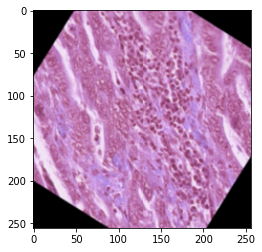

In [83]:
i = 2
plt.imshow(images_aug[i])

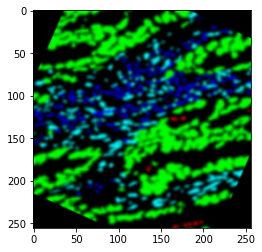

In [84]:
plt.imshow(maskes_aug[i])

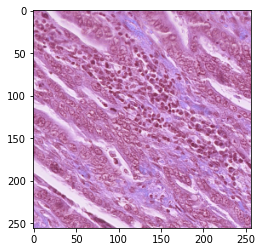

In [81]:
plt.imshow(train_images[i])

In [29]:
X = train_images/255
Y = train_maskedLabels/255

Parameters for DataGenerator:

In [30]:
augImages = 'augImages'
data_gen_args = dict( 
    
      rotation_range=40,
      zoom_range=[0.8, 1.2],
      fill_mode='nearest',
      width_shift_range=0.2,
    #   shear_range=0.2,
      horizontal_flip=True ,
      rescale = 1/255.,
)

### Image Generators for multiclass segmentation:

In [31]:
imgs_dataGen = ImageDataGenerator(**data_gen_args)
masks_dataGen = ImageDataGenerator(**data_gen_args)

imgs_dataGen.fit(train_images, augment=True, seed=1)
imgs_dataGen.fit(train_maskedLabels, augment=True, seed=1)

# image_generator = imgs_dataGen.flow_from_directory(
#     os.path.join(base_folder, sub_folder[0], imgs),
#     class_mode=None,
#     target_size = (256, 256),
#     batch_size = 4,
#     save_to_dir = os.path.join(base_folder, sub_folder[0], augImages, 'image'),
#     save_format="png",
#     seed=1
# )

# mask_generator = masks_dataGen.flow_from_directory(
#     os.path.join(base_folder, sub_folder[0], 'maskedLabels'),
#     class_mode=None,
#     target_size = (256, 256),
#     batch_size = 4,
#     save_to_dir = os.path.join(base_folder, sub_folder[0], augImages, 'mask'),
#     save_format="png",
#     seed=1
# )

image_generator = imgs_dataGen.flow(
    train_images,
    batch_size = 4,
    save_to_dir = os.path.join(base_folder, sub_folder[0], augImages, 'image'),
    # save_format="png",
    seed=1
)

mask_generator = masks_dataGen.flow(
    train_maskedLabels,
    batch_size = 4,
    save_to_dir = os.path.join(base_folder, sub_folder[0], augImages, 'multiclass','mask'),
    # save_format="png",
    seed=1
)

train_generator = zip(image_generator, mask_generator)

### Image Generators for each class for binary segmentation:

In [32]:
binary_masks_dataGen = ImageDataGenerator(**data_gen_args)
binary_masks_dataGen.fit(train_maskedLabels, augment=True, seed=1)

train_generators = []

for i in range(0, len(class_labels)-1):

    bin_mask_generator = masks_dataGen.flow(
        masked_batches[i],
        batch_size = 4,
        save_to_dir = os.path.join(base_folder, sub_folder[0], augImages, 'binary', 'mask'),
        # save_format="png",
        seed=1
    )
    train_generators.append(zip(image_generator, bin_mask_generator))


In [33]:
TRAIN_LENGTH = len(os.listdir(os.path.join(base_folder, sub_folder[0], imgs, cls)))

## Loading Test Data:

we use test data only for evaluation and not in the training process.

In [34]:
test_images = dataSet_from_Images(dest_testImages, H, W)
test_maskedLabels = dataSet_from_Images(dest_testMaskedLabels, H, W)   # this masks are for multi class segmentation..

creating data set from dir CoNSeP/Test/Images/imgs: 100%|██████████| 14/14 [00:00<00:00, 28.25it/s]
creating data set from dir CoNSeP/Test/maskedLabels/imgs: 100%|██████████| 14/14 [00:00<00:00, 56.52it/s]


Binary segmentation test data:

In [35]:
bin_path = os.path.join(base_folder,sub_folder[1] ,'binary')
test_masked_batches = []   # every batch in this list is for one class for example, masked_batches[0] is about masked images of recoreds according to class label 1 (other)
for i in range (1,len(class_labels)):
    test_masked_batches.append(dataSet_from_Images(os.path.join(bin_path, str(i)), H, W))

creating data set from dir CoNSeP/Test/binary/7: 100%|██████████| 14/14 [00:00<00:00, 55.85it/s]


### Normalizing test data sampels:

In [36]:
test_images = test_images/255. 
test_maskedLabels = test_maskedLabels/255.

for i in range(len(test_masked_batches)):
    test_masked_batches[i] = test_masked_batches[i] / 255.

## Multiclass Model:

In [37]:
model = sm.Unet('resnet34', classes=3, activation='softmax', encoder_weights='imagenet', encoder_freeze=True)
model.summary()

85532672/85521592 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
___________________________

In [38]:
model.trainable = True     # we set this true for fine tuneing.
model.compile(optimizer=Adam(learning_rate=1e-5),     
    loss=sm.losses.dice_loss,
    metrics=[sm.metrics.iou_score, sm.metrics.FScore()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

Fine tuning for Multiclass Model:

In [39]:
# pre train decoder
model.fit(train_generator, epochs=2, steps_per_epoch=TRAIN_LENGTH // 4, batch_size=4)


Epoch 1/2
6/6 [==============================] - 39s 306ms/step - loss: 0.9008 - iou_score: 0.0537 - f1-score: 0.0992
Epoch 2/2
6/6 [==============================] - 4s 307ms/step - loss: 0.9003 - iou_score: 0.0534 - f1-score: 0.0987


In [41]:
hsMulti = model.fit(train_generator, epochs = 120, steps_per_epoch=TRAIN_LENGTH // 4, batch_size=4)
# model.fit(x=X, y=Y, epochs = 10, steps_per_epoch=len(X) // 4, batch_size=4)

Epoch 1/120
6/6 [==============================] - 2s 331ms/step - loss: 0.9092 - iou_score: 0.0490 - f1-score: 0.0902
Epoch 2/120
6/6 [==============================] - 2s 299ms/step - loss: 0.9125 - iou_score: 0.0474 - f1-score: 0.0882
Epoch 3/120
6/6 [==============================] - 2s 310ms/step - loss: 0.8952 - iou_score: 0.0566 - f1-score: 0.1048
Epoch 4/120
6/6 [==============================] - 2s 303ms/step - loss: 0.9088 - iou_score: 0.0500 - f1-score: 0.0925
Epoch 5/120
6/6 [==============================] - 2s 306ms/step - loss: 0.9022 - iou_score: 0.0535 - f1-score: 0.0986
Epoch 6/120
6/6 [==============================] - 2s 303ms/step - loss: 0.8996 - iou_score: 0.0555 - f1-score: 0.1002
Epoch 7/120
6/6 [==============================] - 2s 322ms/step - loss: 0.9093 - iou_score: 0.0490 - f1-score: 0.0907
Epoch 8/120
6/6 [==============================] - 2s 356ms/step - loss: 0.8992 - iou_score: 0.0555 - f1-score: 0.1026
Epoch 9/120
6/6 [==============================]

## Evaluation of model multiClass:

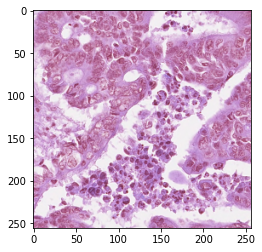

In [60]:
s = 10
pr = model.predict(test_images)
plt.imshow(test_images[s])

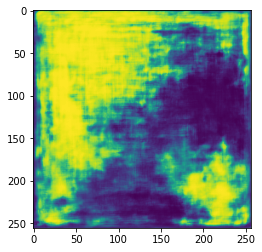

In [61]:
im = pr[s]
im = im[:,:,0]   # deleting last dim for solving problem for imshow in plt.
plt.imshow(im)

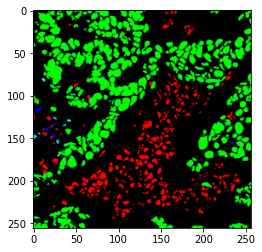

In [62]:
plt.imshow(test_maskedLabels[s])

In [63]:
a = model.evaluate(test_images, test_maskedLabels, verbose=2)

1/1 - 1s - loss: 0.9392 - iou_score: 0.0319 - f1-score: 0.0608


Text(0.5, 0, 'Epoch')

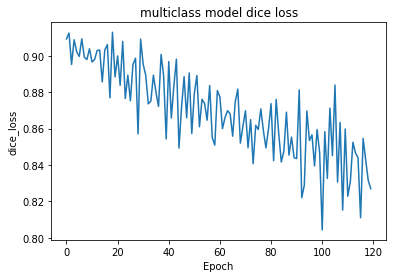

In [64]:
plt.plot(hsMulti.history['loss'])
plt.title('multiclass model dice loss')
plt.ylabel('dice_loss')
plt.xlabel('Epoch')

Text(0.5, 1.0, 'multiclass model iou score')

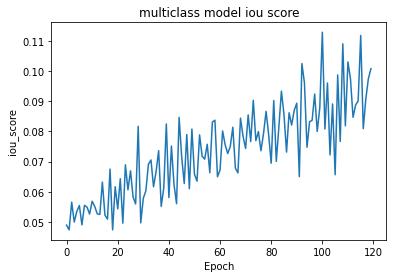

In [65]:
plt.plot(hsMulti.history['iou_score'])
# plt.plot(hs1.history['val_loss'])
plt.ylabel('iou_score')
plt.xlabel('Epoch')
# plt.legend(['Train-loss', 'Train-iou'], loc='upper right')
plt.title('multiclass model iou score')

## binary models:

### for Class 1:

In [37]:
model_class1 = sm.Unet('resnet34', classes=1, activation='sigmoid', encoder_weights='imagenet', encoder_freeze=True)
model_class1.summary()

85532672/85521592 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
___________________________

In [38]:
model_class1.trainable = True
model_class1.compile(optimizer=Adam(learning_rate=1e-5),     
    #loss=sm.losses.binary_focal_loss,
    loss = sm.losses.dice_loss,
    metrics=[sm.metrics.iou_score, sm.metrics.FScore(), 'binary_accuracy'])
model_class1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

#### Fine_Tuning for binary model 1:

In [39]:
# pretrain model decoder
class_label = 0
model_class1.fit(train_generators[class_label], epochs=2, steps_per_epoch=TRAIN_LENGTH // 4, batch_size=4)

Epoch 1/2
6/6 [==============================] - 39s 185ms/step - loss: 0.9979 - iou_score: 0.0011 - f1-score: 0.0021 - binary_accuracy: 0.8789
Epoch 2/2
6/6 [==============================] - 3s 183ms/step - loss: 0.9982 - iou_score: 8.9186e-04 - f1-score: 0.0018 - binary_accuracy: 0.8837


In [40]:
# hs1 = model_class1.fit(train_generators[class_label], epochs = 135, steps_per_epoch=TRAIN_LENGTH // 4, batch_size=4, validation_data=(test_images, test_masked_batches[class_labels][:,:,0]))
hs1 = model_class1.fit(train_generators[class_label], epochs = 100, steps_per_epoch=TRAIN_LENGTH // 4, batch_size=4)

Epoch 1/100
6/6 [==============================] - 1s 212ms/step - loss: 0.9973 - iou_score: 0.0013 - f1-score: 0.0027 - binary_accuracy: 0.8811
Epoch 2/100
6/6 [==============================] - 1s 204ms/step - loss: 0.9989 - iou_score: 5.4081e-04 - f1-score: 0.0011 - binary_accuracy: 0.8825
Epoch 3/100
6/6 [==============================] - 1s 200ms/step - loss: 0.9973 - iou_score: 0.0013 - f1-score: 0.0026 - binary_accuracy: 0.8823
Epoch 4/100
6/6 [==============================] - 1s 200ms/step - loss: 0.9969 - iou_score: 0.0015 - f1-score: 0.0030 - binary_accuracy: 0.8801
Epoch 5/100
6/6 [==============================] - 1s 199ms/step - loss: 0.9984 - iou_score: 7.9403e-04 - f1-score: 0.0016 - binary_accuracy: 0.8810
Epoch 6/100
6/6 [==============================] - 1s 196ms/step - loss: 0.9976 - iou_score: 0.0012 - f1-score: 0.0023 - binary_accuracy: 0.8805
Epoch 7/100
6/6 [==============================] - 1s 209ms/step - loss: 0.9978 - iou_score: 0.0011 - f1-score: 0.0022 - b

In [41]:
hs1.history.keys()

dict_keys(['loss', 'iou_score', 'f1-score', 'binary_accuracy'])

Text(0.5, 0, 'Epoch')

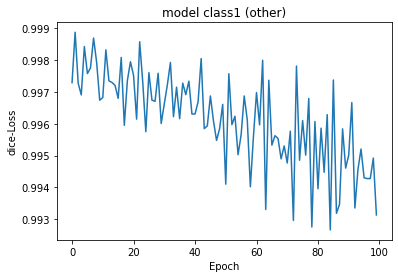

In [42]:
mainClass_label = class_label + 1
plt.plot(hs1.history['loss'])
plt.title('model class{} ({})'.format(mainClass_label, class_labels[mainClass_label]))
plt.ylabel('dice-Loss')
plt.xlabel('Epoch')

Text(0.5, 1.0, 'model class1 (other)')

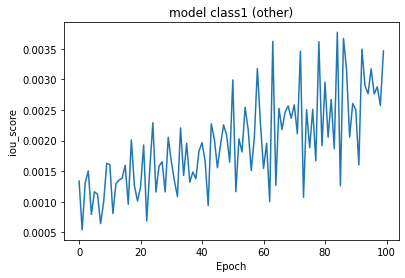

In [43]:
plt.plot(hs1.history['iou_score'])
# plt.plot(hs1.history['val_loss'])
plt.ylabel('iou_score')
plt.xlabel('Epoch')
# plt.legend(['Train-loss', 'Train-iou'], loc='upper right')
plt.title('model class{} ({})'.format(mainClass_label, class_labels[mainClass_label]))

Text(0.5, 1.0, 'model class1 (other)')

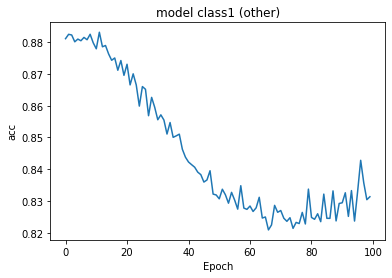

In [44]:
plt.plot(hs1.history['binary_accuracy'])
# plt.plot(hs1.history['val_loss'])
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.title('model class{} ({})'.format(mainClass_label, class_labels[mainClass_label]))


## Evaluation on test data for class 1 model:

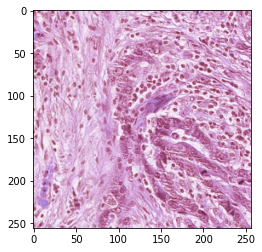

In [102]:
s = 9
pr = model_class1.predict(test_images)
plt.imshow(test_images[s])

In [103]:
im = pr[s]
im = im[:,:,0]   # deleting last dim for solving problem for imshow in plt.
im.shape

(256, 256)

predicted image by binary model 1:

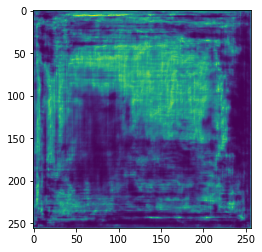

In [104]:
plt.imshow(im)  # segmentaion result of model

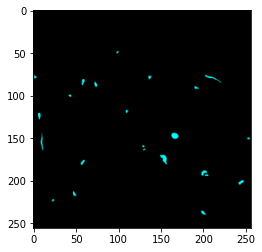

In [105]:
plt.imshow(test_masked_batches[class_label][s])

In [ ]:
a = model_class1.evaluate(test_images, test_maskedLabels, verbose=2)

### For class 5:

In [ ]:

model_class5 = sm.Unet('resnet34', classes=1, activation='sigmoid', encoder_weights='imagenet', encoder_freeze=True)
model_class5.summary()

85532672/85521592 [==============================] - 4s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
___________________________

In [ ]:
model_class5.trainable = True   # for fine tuning
model_class5.compile(optimizer=Adam(learning_rate=1e-5),     
    #loss=sm.losses.binary_focal_loss,
    loss = sm.losses.dice_loss,
    metrics=[sm.metrics.iou_score, sm.metrics.FScore(), 'binary_accuracy'])
model_class5.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

Fine_Tuning for binary model 5:

In [ ]:
# pretrain model decoder
class_label = 4
model_class5.fit(train_generators[class_label], epochs=3, steps_per_epoch=TRAIN_LENGTH // 4, batch_size=4)

Epoch 1/3
6/6 [==============================] - 39s 277ms/step - loss: 0.9508 - iou_score: 0.0256 - f1-score: 0.0492 - binary_accuracy: 0.5665
Epoch 2/3
6/6 [==============================] - 4s 278ms/step - loss: 0.9623 - iou_score: 0.0193 - f1-score: 0.0370 - binary_accuracy: 0.5691
Epoch 3/3
6/6 [==============================] - 2s 277ms/step - loss: 0.9437 - iou_score: 0.0304 - f1-score: 0.0576 - binary_accuracy: 0.5525


In [ ]:
hs5 = model_class5.fit(train_generators[class_label], epochs = 200, steps_per_epoch=TRAIN_LENGTH // 4, batch_size=4)

Epoch 1/200
6/6 [==============================] - 2s 278ms/step - loss: 0.9538 - iou_score: 0.0235 - f1-score: 0.0450 - binary_accuracy: 0.5609
Epoch 2/200
6/6 [==============================] - 2s 278ms/step - loss: 0.9506 - iou_score: 0.0253 - f1-score: 0.0483 - binary_accuracy: 0.5632
Epoch 3/200
6/6 [==============================] - 2s 273ms/step - loss: 0.9445 - iou_score: 0.0284 - f1-score: 0.0541 - binary_accuracy: 0.5573
Epoch 4/200
6/6 [==============================] - 2s 275ms/step - loss: 0.9575 - iou_score: 0.0221 - f1-score: 0.0428 - binary_accuracy: 0.5617
Epoch 5/200
6/6 [==============================] - 2s 271ms/step - loss: 0.9515 - iou_score: 0.0251 - f1-score: 0.0482 - binary_accuracy: 0.5588
Epoch 6/200
6/6 [==============================] - 2s 286ms/step - loss: 0.9473 - iou_score: 0.0276 - f1-score: 0.0527 - binary_accuracy: 0.5550
Epoch 7/200
6/6 [==============================] - 2s 287ms/step - loss: 0.9493 - iou_score: 0.0261 - f1-score: 0.0499 - binary_ac

Text(0.5, 0, 'Epoch')

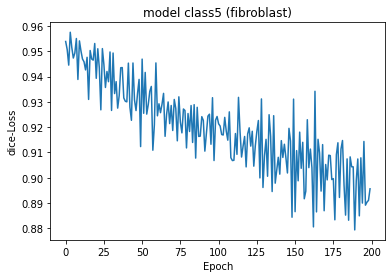

In [ ]:
mainClass_label = class_label + 1
plt.plot(hs5.history['loss'])
plt.title('model class{} ({})'.format(mainClass_label, class_labels[mainClass_label]))
plt.ylabel('dice-Loss')
plt.xlabel('Epoch')

Text(0.5, 1.0, 'model class5 (fibroblast)')

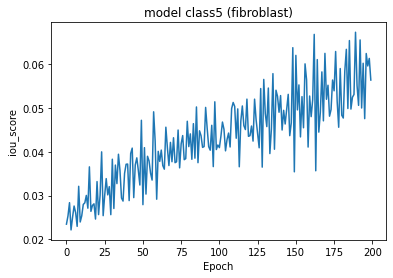

In [ ]:
plt.plot(hs5.history['iou_score'])
# plt.plot(hs1.history['val_loss'])
plt.ylabel('iou_score')
plt.xlabel('Epoch')
# plt.legend(['Train-loss', 'Train-iou'], loc='upper right')
plt.title('model class{} ({})'.format(mainClass_label, class_labels[mainClass_label]))

Text(0.5, 1.0, 'model class5 (fibroblast)')

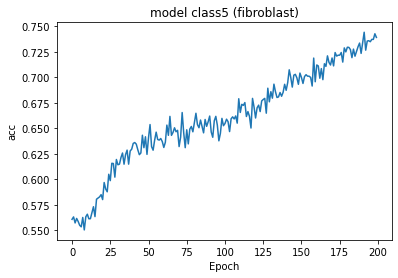

In [ ]:
plt.plot(hs5.history['binary_accuracy'])
# plt.plot(hs1.history['val_loss'])
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.title('model class{} ({})'.format(mainClass_label, class_labels[mainClass_label]))

## Evaluation on test data for class 5 model:

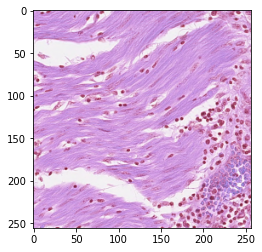

In [ ]:
s = 1
pr = model_class5.predict(test_images)
plt.imshow(test_images[s])

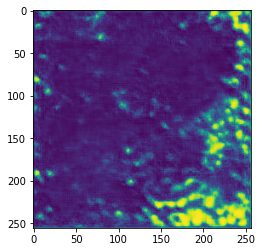

In [ ]:
im = pr[s]
im = im[:,:,0]   # deleting last dim for solving problem for imshow in plt.
plt.imshow(im)   # segmentaion result of model

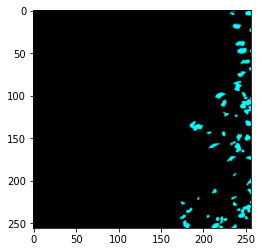

In [ ]:
plt.imshow(test_masked_batches[class_label][s])

In [ ]:
a = model_class5.evaluate(test_images, test_maskedLabels, verbose=2)

1/1 - 1s - loss: 0.8596 - iou_score: 0.0769 - f1-score: 0.1404 - binary_accuracy: 0.8042


### For class 6:

In [37]:

model_class6 = sm.Unet('resnet34', classes=1, activation='sigmoid', encoder_weights='imagenet', encoder_freeze=True)
model_class6.summary()

85532672/85521592 [==============================] - 4s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
___________________________

In [38]:
model_class6.trainable = True
model_class6.compile(optimizer=Adam(learning_rate=1e-5),     
    #loss=sm.losses.binary_focal_loss,
    loss = sm.losses.dice_loss,
    metrics=[sm.metrics.iou_score, sm.metrics.FScore(), 'binary_accuracy'])
model_class6.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

Fine_Tuning for binary model 6:

In [39]:
# pretrain model decoder
class_label = 5
model_class6.fit(train_generators[class_label], epochs=3, steps_per_epoch=TRAIN_LENGTH // 4, batch_size=4)

Epoch 1/3
6/6 [==============================] - 39s 280ms/step - loss: 0.9899 - iou_score: 0.0051 - f1-score: 0.0101 - binary_accuracy: 0.6067
Epoch 2/3
6/6 [==============================] - 4s 283ms/step - loss: 0.9793 - iou_score: 0.0114 - f1-score: 0.0223 - binary_accuracy: 0.5944
Epoch 3/3
6/6 [==============================] - 2s 282ms/step - loss: 0.9896 - iou_score: 0.0052 - f1-score: 0.0103 - binary_accuracy: 0.5986


In [40]:
hs6 = model_class6.fit(train_generators[class_label], epochs = 200, steps_per_epoch=TRAIN_LENGTH // 4, batch_size=4)

Epoch 1/200
6/6 [==============================] - 2s 286ms/step - loss: 0.9845 - iou_score: 0.0083 - f1-score: 0.0164 - binary_accuracy: 0.6018
Epoch 2/200
6/6 [==============================] - 2s 279ms/step - loss: 0.9846 - iou_score: 0.0087 - f1-score: 0.0170 - binary_accuracy: 0.5978
Epoch 3/200
6/6 [==============================] - 2s 276ms/step - loss: 0.9827 - iou_score: 0.0094 - f1-score: 0.0184 - binary_accuracy: 0.5954
Epoch 4/200
6/6 [==============================] - 2s 278ms/step - loss: 0.9822 - iou_score: 0.0093 - f1-score: 0.0183 - binary_accuracy: 0.5959
Epoch 5/200
6/6 [==============================] - 2s 273ms/step - loss: 0.9829 - iou_score: 0.0090 - f1-score: 0.0176 - binary_accuracy: 0.6014
Epoch 6/200
6/6 [==============================] - 2s 298ms/step - loss: 0.9819 - iou_score: 0.0092 - f1-score: 0.0181 - binary_accuracy: 0.5968
Epoch 7/200
6/6 [==============================] - 2s 295ms/step - loss: 0.9869 - iou_score: 0.0064 - f1-score: 0.0126 - binary_ac

Text(0.5, 0, 'Epoch')

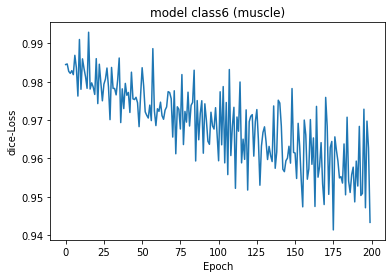

In [41]:
mainClass_label = class_label + 1
plt.plot(hs6.history['loss'])
plt.title('model class{} ({})'.format(mainClass_label, class_labels[mainClass_label]))
plt.ylabel('dice-Loss')
plt.xlabel('Epoch')

Text(0.5, 1.0, 'model class6 (muscle)')

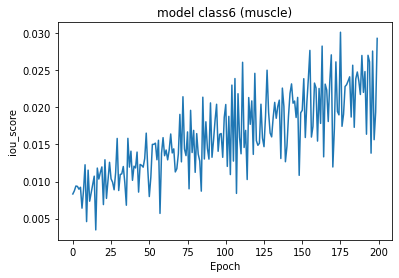

In [42]:
plt.plot(hs6.history['iou_score'])
# plt.plot(hs1.history['val_loss'])
plt.ylabel('iou_score')
plt.xlabel('Epoch')
# plt.legend(['Train-loss', 'Train-iou'], loc='upper right')
plt.title('model class{} ({})'.format(mainClass_label, class_labels[mainClass_label]))

Text(0.5, 1.0, 'model class6 (muscle)')

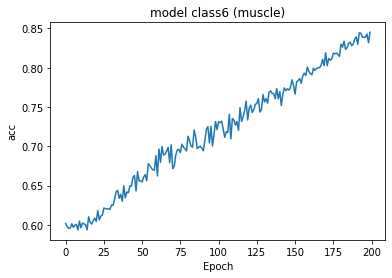

In [43]:
plt.plot(hs6.history['binary_accuracy'])
# plt.plot(hs1.history['val_loss'])
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.title('model class{} ({})'.format(mainClass_label, class_labels[mainClass_label]))

## Evaluation on test data for class 6 model:

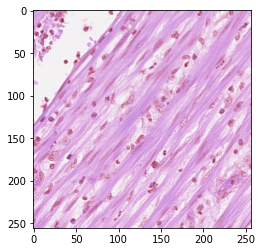

In [75]:
s = 11
pr = model_class6.predict(test_images)
plt.imshow(test_images[s])

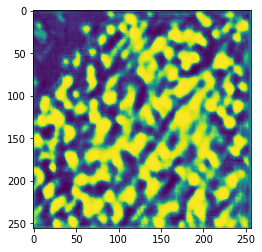

In [76]:
im = pr[s]
im = im[:,:,0]   # deleting last dim for solving problem for imshow in plt.
plt.imshow(im)   # segmentaion result of model

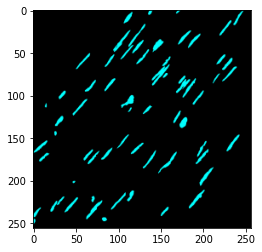

In [77]:
plt.imshow(test_masked_batches[class_label][s])

In [78]:
a = model_class6.evaluate(test_images, test_maskedLabels, verbose=2)

1/1 - 1s - loss: 0.8683 - iou_score: 0.0728 - f1-score: 0.1317 - binary_accuracy: 0.6909


## Some augmented Images genarated using DataGenerator:

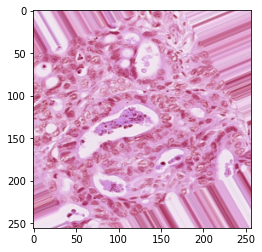

In [ ]:
p1 = os.path.join(base_folder, sub_folder[0], augImages, 'image')
# p2 = os.path.join(base_folder, sub_folder[0], augImages, 'multiclass', 'mask')
p3 = os.path.join(base_folder, sub_folder[0], augImages, 'binary', 'mask')

plt.imshow(plt.imread(os.path.join(p1, os.listdir(p1)[2]))) 

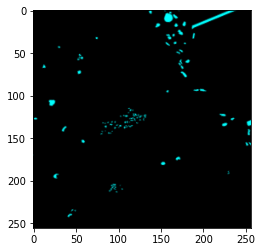

In [ ]:
plt.imshow(plt.imread(os.path.join(p3, os.listdir(p3)[2]))) 